# Trainer
Trains ML model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd

from PIL import Image

from os import listdir
from os.path import isfile, join

from engine import train_one_epoch, evaluate
import utils

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Import Data

## Define Dataset

In [18]:
class SoccerDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        # Load in images and bounding boxes
        self.imgs = list(listdir(join(root, "images")))
        self.bnd_boxes = pd.read_json(join(root, "bndboxes.json"))
    
    def __getitem__(self, index):
        # Load in image + bnd box
        img = Image.open(join(self.root, f"images/{self.imgs[index]}")).convert("RGB")
        bnd_box = self.bnd_boxes.iloc[index].to_numpy()
        bnd_box = torch.as_tensor(bnd_box, dtype=torch.float32)

        # Transform image
        if self.transforms is not None:
            img = self.transforms(img)
        
        # Define target
        target = {}
        target["boxes"] = torch.unsqueeze(bnd_box, dim=0)
        target["labels"] = torch.tensor([1])
        target["image_id"] = torch.tensor([index])
        target["area"] = torch.tensor([1])
        target["iscrowd"] = torch.tensor([0])

        # Return image and bnd box
        return img, target


    def __len__(self):
        return len(self.imgs)

## Load in MakeML images

In [19]:
data_path = '../data/'
TRAIN_TEST_SPLIT = 0.2 # % of data being test
BATCH_SIZE = 16

# Transform tensor for training data
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = SoccerDataset(
    root=data_path,
    transforms=train_transform
)

num_train = int(len(train_dataset) * (1 - TRAIN_TEST_SPLIT))
num_test  = int(len(train_dataset) - num_train)

print(f"Train dataset size: {num_train}")
print(f"Test  dataset size: {num_test}")

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(train_dataset)).tolist()
dataset_train = torch.utils.data.Subset(train_dataset, indices[:-num_test])
dataset_test = torch.utils.data.Subset(train_dataset, indices[-num_test:])

# Define data loaders
train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=BATCH_SIZE,
    collate_fn = utils.collate_fn
)

test_loader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    collate_fn = utils.collate_fn
)


Train dataset size: 145
Test  dataset size: 37


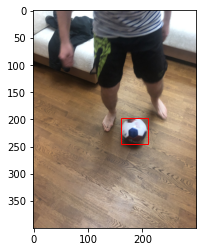

In [4]:
# show sample image
for i, batch in enumerate(train_loader):
    k = 0 # index of image to show

    imgs = batch[0]
    img = imgs[k]
    npimg = img.numpy()

    # Draw image
    fig, ax = plt.subplots()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

    # Draw bounding box
    target = batch[1][k]
    bnd_box = target["boxes"][0]

    xmin = bnd_box[0]
    ymin = bnd_box[1]
    xmax = bnd_box[2]
    ymax = bnd_box[3]

    width = xmax - xmin
    height = ymax - ymin

    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.show()
    
    break

## Load in Coco Class Labels

In [6]:
coco_labels = []

f = open('../test.txt')
lines = f.readlines()

for line in lines:
    coco_labels.append(line.strip('\n'))

print(coco_labels)

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush']


# Network Architecture
## Load in Pretrained

In [31]:
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequen

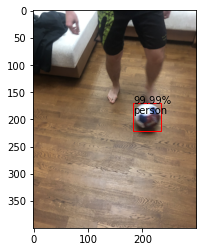

In [59]:
# Sample detections
img = batch[0][6]
detections = model([img])[0]

# Draw image
fig, ax = plt.subplots()
ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))

for i in range(len(detections['boxes'])):
    confidence = detections['scores'][i]

    if confidence > 0.3:
        box = detections["boxes"][i].detach().cpu().numpy()
        (xmin, ymin, xmax, ymax) = box.astype("int")

        width = xmax - xmin
        height = ymax - ymin

        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        ax.text(xmin, ymin, f"{float(confidence * 100):.2f}%")
        ax.text(xmin, ymin+20, coco_labels[detections["labels"][i] - 1])

plt.show()

## Change output layer

In [32]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

num_classes = 2 # ball + background

# Remove old box predictor and slap on our new one 
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

"""
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256

# and replace the mask predictor with a new one
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                   hidden_layer,
                                                   num_classes)
"""

'\nin_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels\nhidden_layer = 256\n\n# and replace the mask predictor with a new one\nmodel.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,\n                                                   hidden_layer,\n                                                   num_classes)\n'

# Training

## Initialize optimizer

In [34]:
LEARNING_RATE = 0.005
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005

# Initialize optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE,
                            momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler to decrease lr during training
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=15,
                                               gamma=0.5)

In [35]:
# Let's train!!
NUM_EPOCHS = 100

for epoch in range(NUM_EPOCHS):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, test_loader, device=device)

Epoch: [0]  [ 0/10]  eta: 0:02:03  lr: 0.000560  loss: 1.0135 (1.0135)  loss_classifier: 0.6282 (0.6282)  loss_box_reg: 0.3289 (0.3289)  loss_objectness: 0.0549 (0.0549)  loss_rpn_box_reg: 0.0014 (0.0014)  time: 12.3211  data: 0.1705
Epoch: [0]  [ 9/10]  eta: 0:00:12  lr: 0.005000  loss: 0.5563 (0.6438)  loss_classifier: 0.2490 (0.3608)  loss_box_reg: 0.2063 (0.2308)  loss_objectness: 0.0517 (0.0512)  loss_rpn_box_reg: 0.0009 (0.0010)  time: 12.1475  data: 0.1390
Epoch: [0] Total time: 0:02:01 (12.1477 s / it)
creating index...
index created!
Test:  [ 0/37]  eta: 0:00:08  model_time: 0.2194 (0.2194)  evaluator_time: 0.0020 (0.0020)  time: 0.2304  data: 0.0090
Test:  [36/37]  eta: 0:00:00  model_time: 0.2623 (0.2455)  evaluator_time: 0.0010 (0.0010)  time: 0.2616  data: 0.0095
Test: Total time: 0:00:09 (0.2564 s / it)
Averaged stats: model_time: 0.2623 (0.2455)  evaluator_time: 0.0010 (0.0010)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @

KeyboardInterrupt: 

# Results

## Predict on Test Dataset

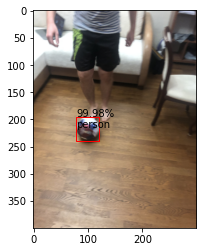

In [61]:
# Sample detections
img, _ = dataset_test[23]
detections = model([img])[0]

# Draw image
fig, ax = plt.subplots()
ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))

for i in range(len(detections['boxes'])):
    confidence = detections['scores'][i]

    if confidence > 0.3:
        box = detections["boxes"][i].detach().cpu().numpy()
        (xmin, ymin, xmax, ymax) = box.astype("int")

        width = xmax - xmin
        height = ymax - ymin

        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        ax.text(xmin, ymin, f"{float(confidence * 100):.2f}%")
        ax.text(xmin, ymin+20, coco_labels[detections["labels"][i] - 1])

plt.show()

## Real Time Detection

In [74]:
import cv2

# Enable we
# '0' is default ID for builtin web cam
# for external web cam ID can be 1 or -1
imcap = cv2.VideoCapture(0)
imcap.set(3, 640) # set width as 640
imcap.set(4, 480) # set height as 480

while True:
    success, im = imcap.read()
    img = im.astype('float64')
    img = np.transpose(img, (2, 0, 1))
    img /= 255
    img = torch.from_numpy(img)
    img = img.float()

    # Draw bounding boxes  
    detections = model([img])[0]

    for i in range(len(detections['boxes'])):
        confidence = detections['scores'][i]

        if confidence > 0.3:
            box = detections["boxes"][i].detach().cpu().numpy()
            (xmin, ymin, xmax, ymax) = box.astype("int")

            width = xmax - xmin
            height = ymax - ymin

            cv2.rectangle(im, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)
            cv2.putText(im, f"{confidence * 100}%", (xmin-5, ymin-5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3, cv2.LINE_AA)

    cv2.imshow('ball_detect', im)
    if cv2.waitKey(10) & 0xFF == ord('q'): break

imcap.release()
cv2.destroyWindow('ball_detect')